In [5]:
import os
import psycopg
import pandas as pd
from tqdm import tqdm
from tqdm import tqdm
import binascii
import polars as pl
import numpy as np
import psycopg

import matplotlib.colors as mcolors    
from matplotlib import pyplot as plt

from tools.utils import basicconfig
from tools.utils.settings import get_all_paths

## In the best returned results, how are distributed Jaccard, Containment and other metrics w.r.t. the area ratio?

In [61]:
test_name, dataset, k, q = 'a_test', 'wikiturlsnap', 10, '100K'
_, _, _, _, _, _, results_extr_dir, _, _, _ = get_all_paths(test_name, dataset, k, q)
extrres = pl.read_csv(f'{results_extr_dir}/final_results_k{k}_q{q}.csv')

In [62]:
measure_data = extrres.select(['area_ratio', 'jaccard_sim', 'multi_jaccard_sim', 'containment', 'overlap_set_sim'])

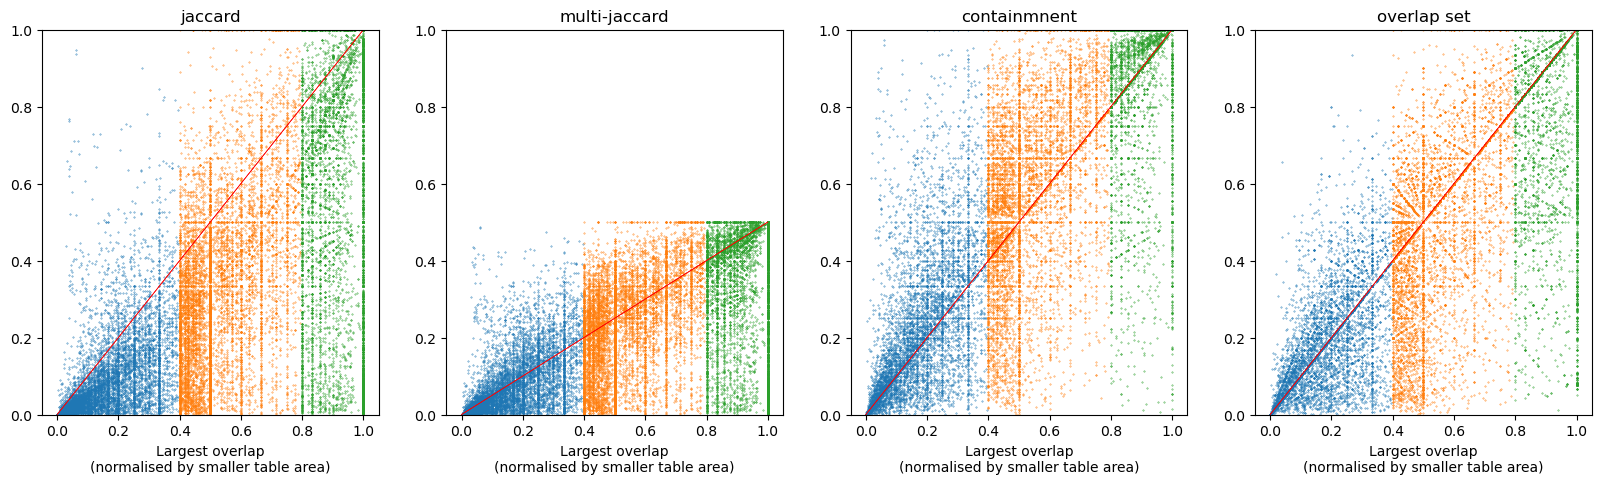

In [148]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
stat = []
sample_size = 10000
for (lb, ub) in [(0, 0.4), (0.4, 0.8), (0.8, 1.1)]:
    
    data = measure_data.filter((lb <= pl.col('area_ratio')) & (pl.col('area_ratio') < ub)).sample(sample_size).to_numpy()
    area_ratio, js, mjs, c, osm = data[:, 0], data[:, 1], data[:, 2], data[:, 3], data[:, 4]

    l = []
    for m in [js, mjs * 2, c, osm]:
        x = m > area_ratio * 1.0  # 5% error
        l.append((np.mean(x), np.std(x)))

    stat += [((lb, ub), l)]
    
    for ax, m, mlabel in zip(axes, [js, mjs, c, osm], ['jaccard', 'multi-jaccard', 'containmnent', 'overlap set']):
        ax.scatter(area_ratio, m, s=0.1)
        ax.set_title(mlabel)
        ax.set_ylim((0, 1))
        ax.set_xlabel('Largest overlap\n(normalised by smaller table area)')
        ax.plot([0, 1] if mlabel != 'multi-jaccard' else [0, 0.5], color='r', linewidth=0.4)

In [149]:
data = [y for x in stat for y in x[1]]

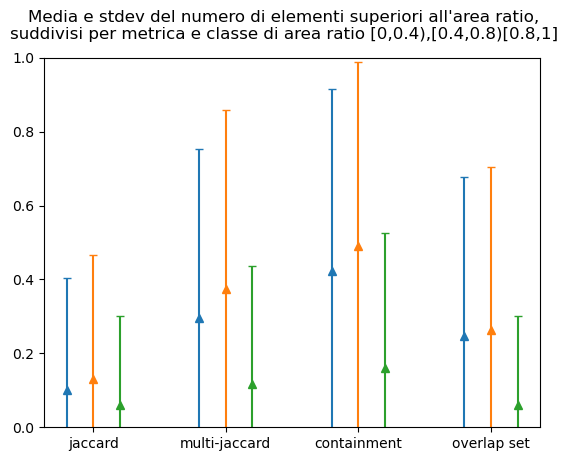

In [150]:
for i in range(4):
    x = [i, i+0.2, i+0.4]
    y = [w[0] for z in stat for w in z[1]][i::4]
    yerr = [w[1] for z in stat for w in z[1]][i::4]
    for j in range(3):
        plt.errorbar(
            x[j], y[j], yerr[j],
            fmt='^',
            linestyle='',
            capsize=3,
            color=list(mcolors.TABLEAU_COLORS.keys())[j]
            # marker='d',
        )
plt.ylim((0, 1))
plt.xticks([0.2, 1.2, 2.2, 3.2], ['jaccard', 'multi-jaccard', 'containment', 'overlap set'])
plt.suptitle('Media e stdev del numero di elementi superiori all\'area ratio,\nsuddivisi per metrica e classe di area ratio [0,0.4), [0.4,0.8), [0.8,1]')
plt.show()

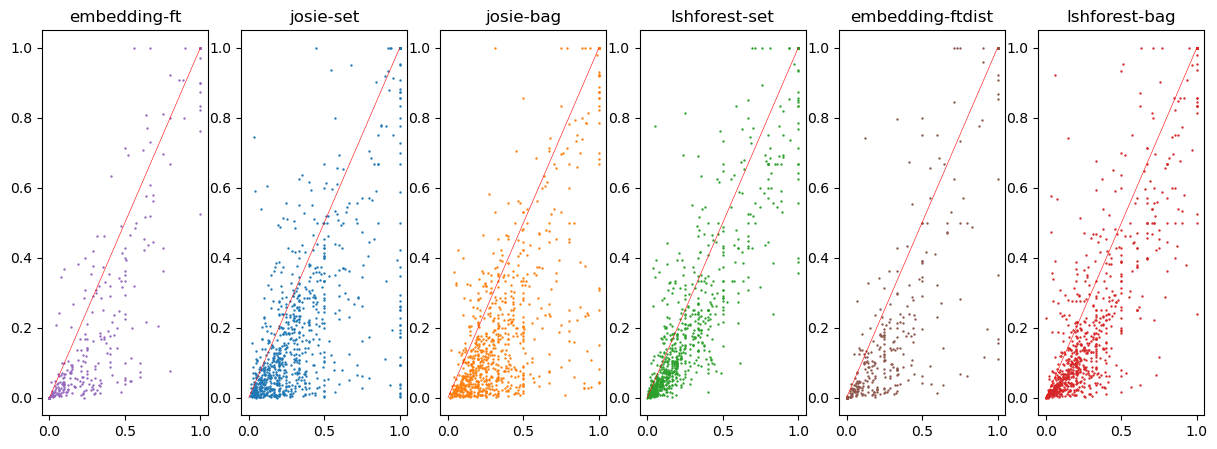

In [79]:
methods = basicconfig.algmodeconfig
colors = list(mcolors.TABLEAU_COLORS.keys())
methods = {m: c for m, c in zip(methods, colors[:len(methods)])}

sample_size = 5000
fig, ax = plt.subplots(1, extrres.select(['algorithm', 'mode']).unique().shape[0], figsize=(15,5))
for i, ((alg, mode), data) in enumerate(extrres.sample(sample_size).select(['algorithm', 'mode', 'area_ratio', 'jaccard_sim']).group_by('algorithm', 'mode')):
    data = data.select('area_ratio', 'jaccard_sim')
    data = data.to_numpy()
    area_ratio, js = data[:, 0], data[:, 1]
    ax[i].scatter(area_ratio, js, s=0.5, label=f'{alg}-{mode}', color=methods[(alg, mode)])
    ax[i].set_title(f"{alg}-{mode}")
    ax[i].plot([0, 1], color='r', linewidth=0.4)

plt.show()

## Information from the JOSIE PostgreSQL tables

In [9]:
_dbconn = psycopg.connect(f"port=5442 host=/tmp dbname=nanni")

Statistics about the mean, stdev, meadian of the posting lists

In [16]:
def joise_invlist_stat(test_name, dataset, mode):
    res = _dbconn.execute(f"SELECT frequency FROM {test_name}_d{dataset}_m{mode}_inverted_lists;")
    res = [r[0] for r in res.fetchall()]
    print(test_name, dataset, mode)
    print(f'mean:   {np.mean(res)}')
    print(f'stddev: {np.std(res)}')
    print(f'median: {np.median(res)}')
    print(f'min:    {np.min(res)}')
    print(f'max:    {np.max(res)}')

In [17]:
joise_invlist_stat('a_test', 'gittables', 'set')

a_test gittables set
mean:   9.393035281104483
stddev: 156.85236056447684
median: 3.0
min:    1
max:    294956


In [18]:
joise_invlist_stat('b_test', 'gittables', 'set')

b_test gittables set
mean:   9.350435512726767
stddev: 109.76565799624402
median: 3.0
min:    1
max:    37003


Get the N most frequent tokens and their original string

In [23]:
def print_most_frequent_tokens(test_name, dataset, mode, N):
    res = _dbconn.execute(f"SELECT raw_token, frequency FROM {test_name}_d{dataset}_m{mode}_inverted_lists ORDER BY frequency DESC LIMIT {N};")

    r = [(binascii.unhexlify(rt).decode('utf-8'), f) for (rt, f) in res]

    tlj = max(len(x[0]) for x in r)
    flj = max(len(str(x[1])) for x in r)

    for rt, f in r:
        print(rt.ljust(tlj), str(f).rjust(flj))

In [24]:
print_most_frequent_tokens('a_test', 'gittables', 'set', 10)

story    294956
comment  294463
tptacek   37003
jacquesm  34426
jrockway  34011
davidw    31883
patio11   30174
Tichy     28124
pg        27788
A         24578


In [25]:
print_most_frequent_tokens('b_test', 'gittables', 'set', 10)

tptacek    37003
jacquesm   34426
jrockway   34011
davidw     31883
patio11    30174
Tichy      28124
pg         27788
A          24578
gaius      24089
tokenadult 23915


In [26]:
print_most_frequent_tokens('a_test', 'gittables', 'bag', 10)

story@#1   294956
comment@#1 294463
comment@#2 293244
comment@#3 292975
comment@#4 292466
comment@#5 291405
comment@#6 289993
comment@#7 288432
story@#2   287423
comment@#8 286732


In [27]:
print_most_frequent_tokens('b_test', 'gittables', 'bag', 10)

tptacek@#1    37003
jacquesm@#1   34426
jrockway@#1   34011
davidw@#1     31883
patio11@#1    30174
Tichy@#1      28124
pg@#1         27788
A@#1          24578
gaius@#1      24089
tokenadult@#1 23915


In [8]:
_dbconn.close()

## How are divided the queries, w.r.t. their set size (set semantic)?

In [32]:
thresholds = [1, 50, 100, 250, 500, 1000, 10000]
bins=thresholds[1:]

In [30]:
test_name, dataset, k, q = 'a_test', 'wikiturlsnap', 10, '50K'
_, _, _, _, _, _, results_extr_dir, _, _, _ = get_all_paths(test_name, dataset, k, q)
extrres = pd.read_csv(f'{results_extr_dir}/final_results_k10_q50K.csv').dropna()

extrres = extrres[['query_id', 'query_size']].drop_duplicates()
tot = extrres.shape[0]
r = []

for i in range(len(thresholds) - 1):    
    s = extrres[(extrres['query_size'] >= thresholds[i]) & (extrres['query_size'] < thresholds[i + 1])].shape[0]
    print(f"{thresholds[i]}<=X<{thresholds[i + 1]}:\t{s}\t{s * 100 / tot}")
    r.append([f"[{thresholds[i]},{thresholds[i + 1]})", round(s / tot, 3)])

1<=X<50:	38512	77.02554051081022
50<=X<100:	6897	13.79427588551771
100<=X<250:	3332	6.664133282665653
250<=X<500:	885	1.7700354007080141
500<=X<1000:	256	0.5120102402048041
1000<=X<10000:	117	0.23400468009360187


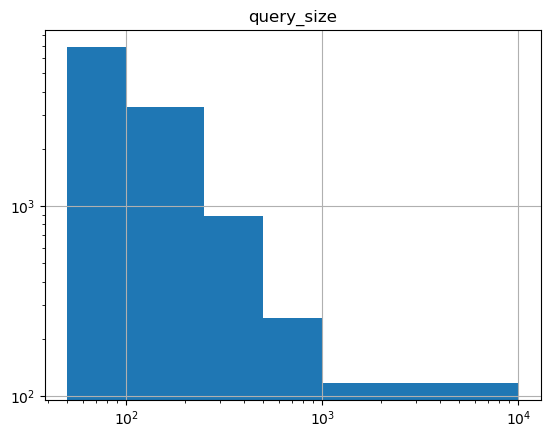

In [33]:
extrres.hist('query_size', bins=bins)
plt.xscale('log')
plt.yscale('log')

In [36]:
test_name, dataset, k, q = 'a_test', 'gittables', 10, '50K'
_, _, _, _, _, _, results_extr_dir, _, _, _ = get_all_paths(test_name, dataset, k, q)
extrres = pd.read_csv(f'{results_extr_dir}/final_results_k10_q50K.csv').dropna()

extrres = extrres[['query_id', 'set_size_q']].drop_duplicates()
tot = extrres.shape[0]
r1 = []

for i in range(len(thresholds) - 1):    
    s = extrres[(extrres['set_size_q'] >= thresholds[i]) & (extrres['set_size_q'] < thresholds[i + 1])].shape[0]
    print(f"{thresholds[i]}<=X<{thresholds[i + 1]}:\t{s}\t{s * 100 / tot}")
    r1.append([f"[{thresholds[i]},{thresholds[i + 1]})", round(s / tot, 3)])

1<=X<50:	10368	20.737244234654078
50<=X<100:	11317	22.63535812148729
100<=X<250:	21133	42.26853611216673
250<=X<500:	3478	6.956417385043102
500<=X<1000:	2547	5.0943056583395006
1000<=X<10000:	1151	2.302138128287697


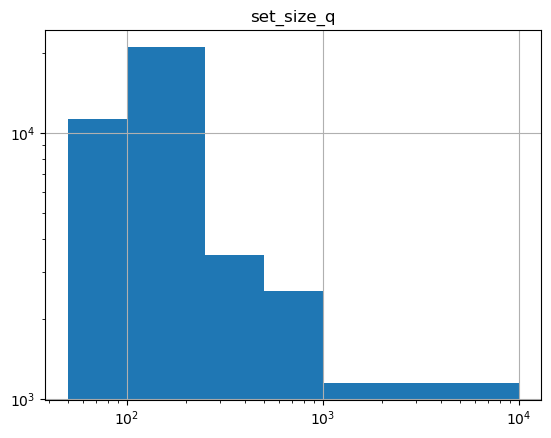

In [37]:
extrres.hist('set_size_q', bins=bins)
plt.xscale('log')
plt.yscale('log')

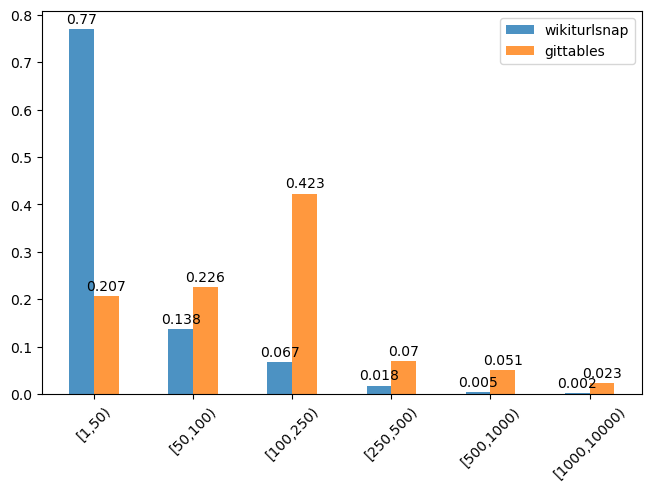

In [38]:
width = 0.25  # the width of the bars
multiplier = 0

x = np.arange(len(r)) 
fig, ax = plt.subplots(layout='constrained')

for data, label in zip([r, r1], ['wikiturlsnap', 'gittables']):
    offset = width * multiplier
    rects = ax.bar(x + offset, [y[1] for y in data], align='edge', alpha=0.8, label=label, width=width)
    ax.bar_label(rects, padding=2)
    multiplier += 1

ax.legend()
ax.set_xticks(x + width, [y[0] for y in data])
ax.tick_params(axis='x', rotation=45)

## How many queries don't have exactly K returned tables for each algorithm/method?

In [39]:
test_name, dataset, k, q = 'a_test', 'wikiturlsnap', 10, '50K'
_, _, _, _, _, _, results_extr_dir, _, _, _ = get_all_paths(test_name, dataset, k, q)
extrres = pd.read_csv(f'{results_extr_dir}/final_results_k10_q50K.csv').dropna()

In [40]:
bad_groups = []
for query_id, q_group in tqdm(extrres.groupby('query_id'), total=extrres['query_id'].unique().shape[0]):
    for (alg, mode), data in q_group.groupby(['algorithm', 'mode']):
        if data.shape[0] < 10:
            bad_groups.append(query_id)
            break

  0%|          | 0/49997 [00:00<?, ?it/s]

100%|██████████| 49997/49997 [00:36<00:00, 1386.75it/s]


In [41]:
len(bad_groups) * 100 / 50000

8.702

## How many failures has SLOTH done in computing the largest overlap?

During the extraction phase, whenever a failure has occurred, the relative pair \<query_id, result_id\> has been stored with a overlap value of -1

In [154]:
dataset = 'gittables'
size = 'standard'
blacklist = []

table_name = f'results_d{dataset}_s{size}'
if len(blacklist) > 1:
    table_name += '_blacklist'
_dbconn = psycopg.connect(f"port=5442 host=/tmp dbname=nanni")
failures = _dbconn.execute(f"SELECT COUNT(*) FROM results_d{dataset}_s{size} WHERE sloth_overlap = -1").fetchone()[0]
total_computed_overlaps = _dbconn.execute(f"SELECT COUNT(*) FROM results_d{dataset}_s{size}").fetchone()[0]

failures * 100 / total_computed_overlaps

0.0020308403414248783